In [1]:
from PIL import Image
import torch
from models.model import MyModel

/opt/conda/envs/mmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
args = argparse.Namespace(
    # Model setting
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-large",
    ffn=True,
    transformer_d_model=768,
    transformer_d_ff=3072,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=12,
    image_vocab_size=16384,
    loc_vocab_size=1000,
    vae_ckpt_path="checkpoints/vqgan.pt",
    max_source_length=256,
    max_target_length=256,
    # Train setting
    pretrain=True, 
    loss='FocalLoss',
    # Dir setting
    root_dir="/data01/",
    result_dir="results/pretrain/cc3m_cc12m_imagenet_inaturalist_places365_redcaps_sun397/enc2_dec12/",
)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model = MyModel(args).to(device)
model.load(result_name='best.pth')

In [5]:
from transformers import AutoTokenizer
from torchvision import transforms
src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256)
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(1000)] + [f"<img_{i}>" for i in range(args.image_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [6]:
import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu().numpy()
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

In [7]:
def show_result(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        print('src_text:', src_text)
        print('tgt_text:', tgt_text)
        src_text = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # print(src_text, tgt_text)

        display(custom_to_pil(src_image[0]))
        output = model(src_image, src_text, tgt_text, return_loss=False, num_beams=4)
        preds = tgt_tokenizer.batch_decode(output[:,1:-1])
        print('pred:', preds[0])

# ImageNet

In [8]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='imagenet', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='imagenet', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

src_text: A photo of kit fox<extra_id_0>
tgt_text: <extra_id_0>.


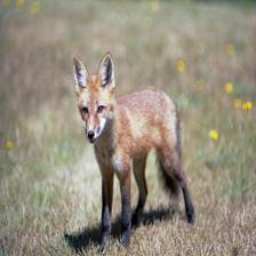

pred: <extra_id_0>.


In [103]:
show_result(train_dataset, idx=400)

# SUN397

src_text: A short image description<extra_id_0> locker room.
tgt_text: <extra_id_0>:<extra_id_1>


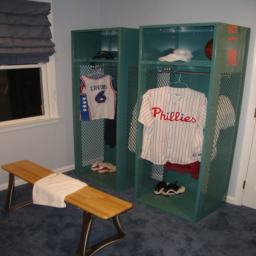

pred: <extra_id_0>.


In [111]:
from data import get_dataset

dataset = get_dataset(args, dataset_name='sun397', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))
show_result(train_dataset, idx=10)

# Places365

src_text: A short<extra_id_0> description: airfield.
tgt_text: <extra_id_0> image<extra_id_1>


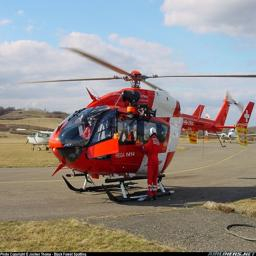

pred: <extra_id_0>.<extra_id_1> a<extra_id_3> a<extra_id_4> a<extra_id_4> a<extra_id_4> a<extra_id_4> a<extra_id_4>


In [112]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='places365', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
# val_dataset = get_dataset(args, dataset_name='places365', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
show_result(train_dataset, idx=10)

# iNaturalist

src_text: An image that shows Animali<extra_id_0> Annelida Clitellata Ha<extra_id_1>taxida<extra_id_2>bricidae Lumbricu<extra_id_3> terres<extra_id_4>s.
tgt_text: <extra_id_0>a<extra_id_1>plo<extra_id_2> Lum<extra_id_3>s<extra_id_4>tri<extra_id_5>


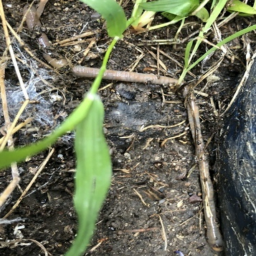

pred: <extra_id_0> a<extra_id_1>


In [113]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='inaturalist', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
# val_dataset = get_dataset(args, dataset_name='inaturalist', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
show_result(train_dataset, idx=10)

# RedCaps

In [116]:
from data import get_dataset
dataset = get_dataset(args, dataset_name="redcaps", src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))

src_text: Churchill is ready<extra_id_0> the holidays!
tgt_text: <extra_id_0> for<extra_id_1>


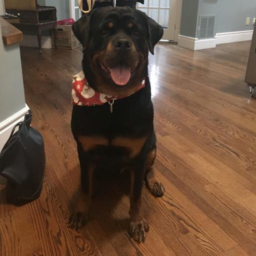

pred: <extra_id_0> a<extra_id_1>


In [117]:
show_result(train_dataset, idx=10)

# CC3M

In [118]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='cc3m', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

src_text: not crazy about the bow<extra_id_0> shoes but other than that in love with this outfit
tgt_text: <extra_id_0> on the<extra_id_1>


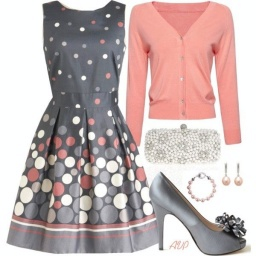

pred: <extra_id_0> s<extra_id_1>


In [119]:
show_result(train_dataset, idx=10)

# CC12M

src_text: Si<extra_id_0>rian Hu<extra_id_1> into the wild. Amazing portrait of a<extra_id_2>berian Husky wolf dog into the<extra_id_3> of the forest on fresh powder snow ground stock<extra_id_4>
tgt_text: <extra_id_0>be<extra_id_1>sky<extra_id_2> Si<extra_id_3> wild<extra_id_4> images


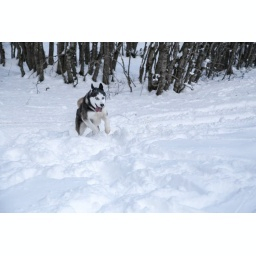

pred: <extra_id_0> a<extra_id_2>


In [120]:
from data import get_dataset
dataset = get_dataset(args, dataset_name="cc12m", src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))
show_result(train_dataset, idx=10)

# 分割テスト

In [ ]:
import random

mask_tokens: list

def generate_target_ids(input_id, mask_prob):
    """This function takes a list of sentences and generates the pair (input_ids, target_ids) for pretraining the
    model. It implements in a simple way the final T5 denoising objective, as per HuggingFace documentation.

    :param mask_prob: Probability of masking a token.
    :param input_ids: A list of sublists, where the sublists are sequences of input ids (tokenized sentences). This
        mutable sublists are modified within this function, masking the tokens that the model has to denoise for
        pretraining.
    :return: The correspondent target sequences of ids for each input sentence, with the unmasked tokens.
    """
    target_id = []
    masked_indexes = sorted(random.sample(range(0, len(input_id)),  # sample a word index in sentence
                                            min(int(mask_prob * len(input_id)),  # number of tokens masked
                                                len(mask_tokens) - 1)))  # but never more than special tokens available
    mask = [(i in masked_indexes)  # this is True or False
            for i in range(len(input_id))]
    i = 0
    end = len(input_id)
    masked_spans_counter = 0
    while i < end:
        if mask[i]:
            current_words_masked = [input_id[i]]
            input_id[i] = mask_tokens[masked_spans_counter]
            masked_spans_counter += 1
            while i + 1 < end and mask[i + 1]:
                current_words_masked.append(input_id[i + 1])
                del input_id[i + 1]
                del mask[i + 1]
                end -= 1
            target_id.extend(current_words_masked)
        else:
            if len(target_id) == 0 or target_id[-1] != mask_tokens[masked_spans_counter]:
                target_id.append(mask_tokens[masked_spans_counter])
        i += 1
    return target_id

In [ ]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-base")
mask_tokens = tokenizer.additional_special_tokens_ids
mask_probability = 0.15

sentence = 'Thank you for inviting me to your party last week. I had a wonderful time.'
sequence = tokenizer.encode_plus(sentence, return_attention_mask=False, verbose=False)[
    "input_ids"]  # performance bottleneck 1 here
target_id = generate_target_ids(sequence, mask_probability)
sequence = torch.tensor(sequence)
sequence = torch.nn.functional.pad(sequence, (0, 512 - len(sequence)), 'constant', 0)
print(sequence.shape)
target_id = torch.tensor(target_id)
target_id = torch.nn.functional.pad(target_id, (0, 512 - len(target_id)), 'constant', 0)
print(target_id.shape)
print(tokenizer.decode(sequence))
print(tokenizer.decode(target_id))

In [ ]:
mask_tokens = src_tokenizer.additional_special_tokens_ids
mask_probability = 0.15

sentence = 'a photo of dog.'
sequence = tgt_tokenizer.encode_plus(sentence, return_attention_mask=False, verbose=False)["input_ids"]  # performance bottleneck 1 here
target_id = generate_target_ids(sequence, mask_probability)
print(sequence)
print(tgt_tokenizer.decode(sequence))
print(target_id)
print(tgt_tokenizer.decode(target_id))

In [ ]:
src_tokenizer.pad_token_id